In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

In [2]:
mat = pd.read_csv("student/student-mat.csv", sep=';')
por = pd.read_csv("student/student-por.csv", sep=';')

In [3]:
df = pd.concat([mat,por])

In [4]:
por.shape

(649, 33)

In [5]:
df.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']

In [6]:
df['final_grade'] = 'na'
df.loc[(df.final_score >= 15) & (df.final_score <= 20), 'final_grade'] = 'good' 
df.loc[(df.final_score >= 10) & (df.final_score <= 14), 'final_grade'] = 'fair' 
df.loc[(df.final_score >= 0) & (df.final_score <= 9), 'final_grade'] = 'poor' 
df.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,...,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_score,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,poor
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,poor
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,fair
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,good
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,fair


### Classification

In [7]:
dfd = df.copy()
dfd = dfd.drop([ 'final_score'], axis=1)

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfd,test_size=0.3)

In [9]:
def preprocessing_data(data):
    bin_dict = {'no': 0, 'yes': 1}
    data['final_grade'] = data['final_grade'].map({'poor': 0, 'fair': 1, 'good':2})
    data['sex'] = data['sex'].map({'F': 0, 'M': 1})
    bin_features = ['school_support', 'family_support', 'paid_classes', 'activities', 'nursery', 'desire_higher_edu', 'internet', 'romantic']
    for feature in bin_features:
        data[feature] = data[feature].map(bin_dict)
    dummies_features = ['school', 'address', 'family_size', 'parents_status', 'mother_job', 'father_job', 'reason', 'guardian']
    for feature in dummies_features:
        data = pd.concat((data, pd.get_dummies(data[feature], prefix=feature + '_')),1)
        data = data.drop([feature], axis=1)
    return (data)

In [10]:
train = preprocessing_data(train)
test = preprocessing_data(test)
train = train[test.columns]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [11]:
X_train = train.drop('final_grade',axis=1)
y_train = train.final_grade

X_test = test.drop('final_grade',axis=1)
y_test = test.final_grade

In [16]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [15]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [15]:
def train_predict_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred), average = 'micro'))
    
    cm = confusion_matrix(y_test, pred)
    
    class_names=[0,1,2] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
   
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print(classification_report(y_test, pred))
    print("Микро-усредненная f1-мера: {:.3f}".format(f1_score(y_test, pred, average="micro")))
    print("Mакро-усредненная f1-мера: {:.3f}".format(f1_score(y_test, pred, average="macro"))) 
    
    

In [16]:
def roc_auc(model, X_train, y_train, X_test, y_test):
    y_train = label_binarize(y_train, classes=[0, 1, 2])
    n_classes = y_train.shape[1]
    y_test = label_binarize(y_test, classes=[0, 1, 2])
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw = 2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

### KNN

Accuracy: 0.822
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        80
           1       0.91      0.77      0.83       181
           2       0.74      0.98      0.85        53

   micro avg       0.82      0.82      0.82       314
   macro avg       0.80      0.86      0.82       314
weighted avg       0.84      0.82      0.82       314

Микро-усредненная f1-мера: 0.822
Mакро-усредненная f1-мера: 0.820


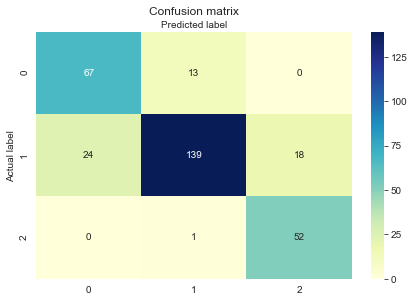

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights = 'distance')
train_predict_model(knn, X_train, y_train, X_test, y_test)


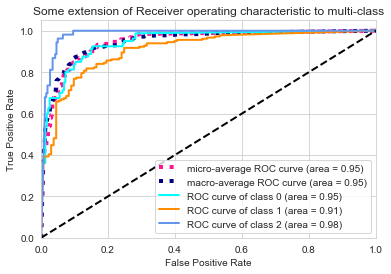

In [23]:
roc_auc(knn, X_train, y_train, X_test, y_test)

In [20]:
from sklearn.model_selection import GridSearchCV, cross_val_score

knn_params = {'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params,cv=5, n_jobs=-1,verbose=True,scoring='accuracy')
knn_grid.fit(X_train, y_train)

print(knn_grid.best_params_)
print(knn_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s


{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.9191919191919192


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.5s finished


### Logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg',fit_intercept=True)

Accuracy: 0.885
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        80
           1       0.92      0.88      0.90       181
           2       0.83      0.94      0.88        53

   micro avg       0.89      0.89      0.89       314
   macro avg       0.87      0.89      0.88       314
weighted avg       0.89      0.89      0.89       314

Микро-усредненная f1-мера: 0.885
Mакро-усредненная f1-мера: 0.880


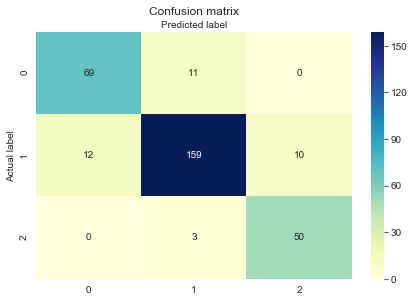

In [25]:
train_predict_model(lr, X_train, y_train, X_test, y_test)

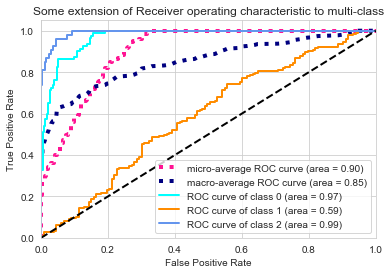

In [26]:
roc_auc(lr, X_train, y_train, X_test, y_test)

### Decision Tree Classification

In [31]:
tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf = 3)

In [28]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5]}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params,cv=5, n_jobs=-1,verbose=True, scoring='accuracy')
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 9, 'min_samples_leaf': 3}
0.9075369075369075


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Accuracy: 0.812
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        80
           1       0.84      0.84      0.84       181
           2       0.80      0.92      0.86        53

   micro avg       0.81      0.81      0.81       314
   macro avg       0.80      0.81      0.80       314
weighted avg       0.81      0.81      0.81       314

Микро-усредненная f1-мера: 0.812
Mакро-усредненная f1-мера: 0.804


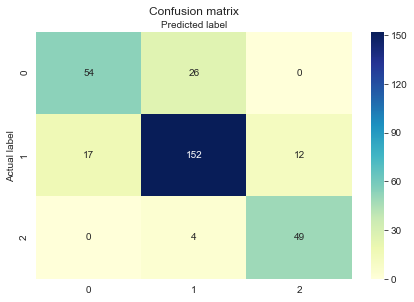

In [32]:
train_predict_model(tree, X_train, y_train, X_test, y_test)

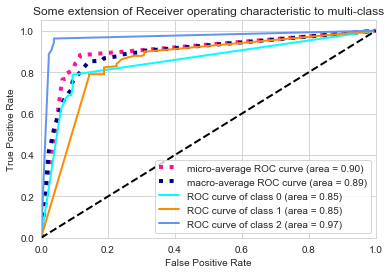

In [33]:
roc_auc(tree, X_train, y_train, X_test, y_test)

### SVC

Accuracy: 0.764
              precision    recall  f1-score   support

           0       0.92      0.41      0.57        80
           1       0.72      0.96      0.82       181
           2       0.87      0.64      0.74        53

   micro avg       0.76      0.76      0.76       314
   macro avg       0.84      0.67      0.71       314
weighted avg       0.80      0.76      0.74       314

Микро-усредненная f1-мера: 0.764
Mакро-усредненная f1-мера: 0.711


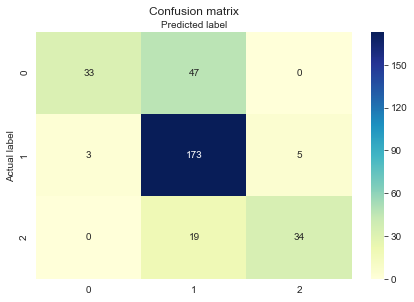

In [36]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', C = 10, gamma = 0.1)

train_predict_model(svc, X_train, y_train, X_test, y_test)

In [35]:
from sklearn.svm import SVC
param_grid = [{'kernel': ['rbf'],
 'C': [0.001, 0.01, 0.1, 1, 10, 100],
 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'kernel': ['linear'],
 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))

Наилучшие значения параметров: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Наилучшее значение кросс-валидац. правильности:0.96


### Random forest

In [39]:
forest = RandomForestClassifier(n_estimators=100, min_samples_leaf= 3, max_depth=9)

In [38]:
tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5], 'n_estimators': [100, 200, 500]}
grid_search = GridSearchCV(RandomForestClassifier(), tree_params, cv=5)
grid_search.fit(X_train, y_train)

print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))
accuracy_score(y_test, grid_search.predict(X_test))

Наилучшие значения параметров: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 100}
Наилучшее значение кросс-валидац. правильности:0.93


0.8694267515923567

Accuracy: 0.879
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        80
           1       0.90      0.88      0.89       181
           2       0.88      0.96      0.92        53

   micro avg       0.88      0.88      0.88       314
   macro avg       0.87      0.89      0.88       314
weighted avg       0.88      0.88      0.88       314

Микро-усредненная f1-мера: 0.879
Mакро-усредненная f1-мера: 0.877


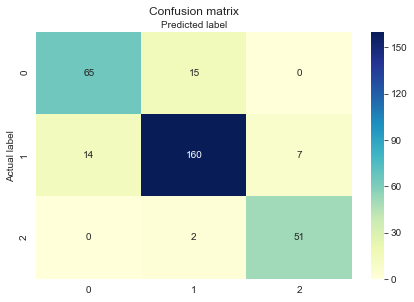

In [40]:
train_predict_model(forest, X_train, y_train, X_test, y_test)

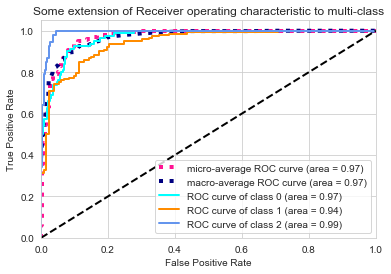

In [41]:
roc_auc(forest, X_train, y_train, X_test, y_test)

### Catboost

In [21]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [12]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
0:	learn: -0.5066692	total: 36.8ms	remaining: 331ms
1:	learn: -0.3824704	total: 51.6ms	remaining: 207ms
2:	learn: -0.3613317	total: 81.7ms	remaining: 191ms
3:	learn: -0.3497324	total: 102ms	remaining: 153ms
4:	learn: -0.3246174	total: 117ms	remaining: 117ms
5:	learn: -0.3164573	total: 132ms	remaining: 88.1ms
6:	learn: -0.3164422	total: 158ms	remaining: 67.7ms
7:	learn: -0.3017295	total: 189ms	remaining: 47.3ms
8:	learn: -0.3005502	total: 220ms	remaining: 24.4ms
9:	learn: -0.3002454	total: 235ms	remaining: 0us
Accuracy: 0.889
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        76
           1       0.89      0.92      0.91       183
           2       0.91      0.95      0.93        55

   micro avg       0.89      0.89      0.89       314
   macro avg       0.89      0.88      0.88   

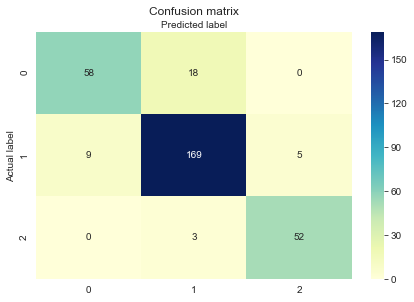

In [17]:
from catboost import Pool, CatBoostClassifier
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=categorical_features_indices)
test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=categorical_features_indices)
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(test_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(test_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(test_dataset, 
                          prediction_type='RawFormulaVal')

print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_class), average = 'micro'))
    
cm = confusion_matrix(y_test, preds_class)
    
class_names=[0,1,2] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
   
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
    
print(classification_report(y_test, preds_class))
print("Микро-усредненная f1-мера: {:.3f}".format(f1_score(y_test, preds_class, average="micro")))
print("Mакро-усредненная f1-мера: {:.3f}".format(f1_score(y_test, preds_class, average="macro"))) 

0:	learn: -0.3034994	total: 18.8ms	remaining: 169ms
1:	learn: -0.2060525	total: 34.1ms	remaining: 136ms
2:	learn: -0.1953570	total: 41.7ms	remaining: 97.3ms
3:	learn: -0.1796334	total: 49.3ms	remaining: 73.9ms
4:	learn: -0.1753762	total: 57.3ms	remaining: 57.3ms
5:	learn: -0.1709726	total: 64.7ms	remaining: 43.1ms
6:	learn: -0.1664097	total: 79.4ms	remaining: 34ms
7:	learn: -0.1650568	total: 110ms	remaining: 27.4ms
8:	learn: -0.1634361	total: 125ms	remaining: 13.9ms
9:	learn: -0.1585960	total: 140ms	remaining: 0us
0:	learn: -0.3843500	total: 12.3ms	remaining: 111ms
1:	learn: -0.2988846	total: 24.1ms	remaining: 96.3ms
2:	learn: -0.2862147	total: 40.1ms	remaining: 93.5ms
3:	learn: -0.2830855	total: 54.8ms	remaining: 82.2ms
4:	learn: -0.2820455	total: 85.3ms	remaining: 85.3ms
5:	learn: -0.2756363	total: 117ms	remaining: 77.7ms
6:	learn: -0.2732919	total: 132ms	remaining: 56.5ms
7:	learn: -0.2702039	total: 147ms	remaining: 36.7ms
8:	learn: -0.2681654	total: 162ms	remaining: 18ms
9:	learn: 

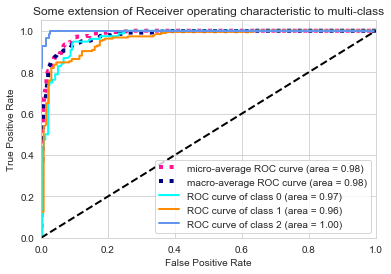

In [18]:
roc_auc(model, X_train, y_train, X_test, y_test)

In [19]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

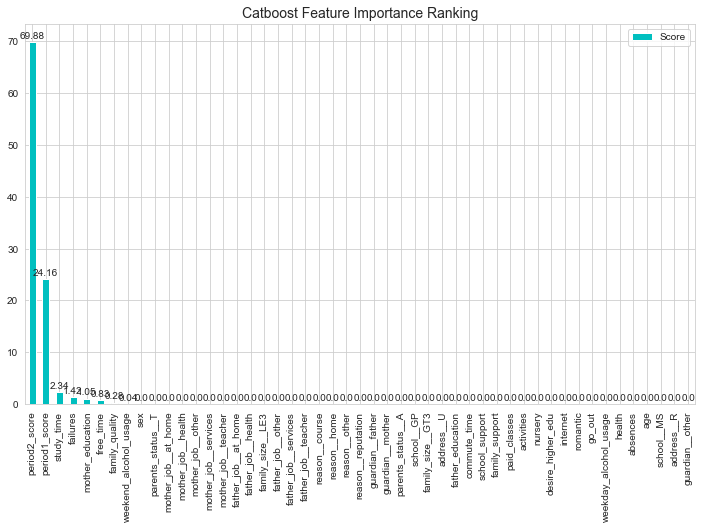

In [20]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()